In [5]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as cvx
%matplotlib inline

In [600]:
X,y=make_classification(n_samples=100, n_classes=2, n_features=2,n_redundant=0,class_sep=1.3, flip_y=0,random_state=42)
t = y.reshape((len(y),1))
t[np.where(t==0)]=-1

In [601]:
def kernel(x,xp):
    return x.dot(xp.T)

Lets plot our data problem first

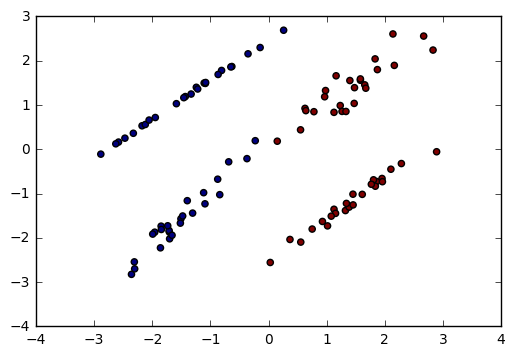

In [602]:
plt.scatter(X.T[0], X.T[1], c=y)

The objective function we want to use is the wolfe-dual $L(a_{n})$.

$L(a_{n}) = -\sum_{n=1}^{N}a_{n} + \sum_{n=1}^{N}\sum_{m=1}^{N}a_{n}a_{m}t_{n}t_{m}K(X_{n}, X_{m})$

We want to minimise $L(a_{n})$ subject to $0 \leq a_{n} \leq C$ and $\sum_{n=1}^{N} a_{n}t_{n}=0$.

We can write the second summation in matrix form $a^{T} S a$, where $S_{ij} = t_{n}t_{m}K(X_{n},X_{m})$

In [603]:
n_samples = len(t)

In [604]:
K = kernel(X,X)
C=500000.0

In [605]:
#cvxopt takes quadratic program as per http://cvxopt.org/userguide/coneprog.html#quadratic-programming
P = cvx.matrix(t.dot(t.T)*K, tc='d') # S matrix from above description
q = cvx.matrix(np.ones((n_samples,1))*-1) #first summation above

In [606]:
#Equality constraint Ax=b, which is constraint sum of antn=0.
A = cvx.matrix(t.T, tc='d') 
b = cvx.matrix(0, tc='d')
#Inequality constraint Gx<=h
#We have two constraints, an>=0, and an<=C.
#-1*I * x <= 0 (zero vector of appropriate length)
#I*x <= C (vector with all elements C)
#cvxopt allows us to stack multiple constraints like so.
G= cvx.matrix(np.vstack([np.identity(n_samples)*-1,np.identity(n_samples)]))
h = cvx.matrix(np.vstack([np.zeros((n_samples,1)), np.ones((n_samples,1))*C]))

In [607]:
res=cvx.solvers.qp(P,q,G,h,A,b) #solve

     pcost       dcost       gap    pres   dres
 0:  4.5837e+10 -1.1255e+13  3e+13  5e-01  9e-10
 1:  1.1317e+11 -1.6673e+12  3e+12  3e-02  5e-07
 2:  7.1312e+10 -2.4774e+11  4e+11  4e-03  6e-08
 3:  1.5846e+10 -2.0101e+10  4e+10  3e-05  4e-10
 4:  2.2964e+09 -2.5627e+09  5e+09  2e-11  1e-10
 5:  3.2965e+08 -3.6532e+08  7e+08  8e-12  4e-11
 6:  4.7263e+07 -5.2099e+07  1e+08  1e-12  2e-11
 7:  6.7724e+06 -7.4564e+06  1e+07  9e-13  5e-12
 8:  9.6991e+05 -1.0685e+06  2e+06  9e-14  2e-12
 9:  1.3875e+05 -1.5333e+05  3e+05  7e-14  1e-12
10:  1.9790e+04 -2.2063e+04  4e+04  6e-14  3e-13
11:  2.8001e+03 -3.1970e+03  6e+03  4e-15  1e-13
12:  3.8672e+02 -4.7202e+02  9e+02  2e-15  5e-14
13:  4.8673e+01 -7.3522e+01  1e+02  8e-16  2e-14
14:  3.5666e+00 -1.6087e+01  2e+01  7e-16  7e-15
15: -2.8402e+00 -2.0194e+01  2e+01  1e-15  5e-15
16: -1.3829e+01 -1.4884e+01  1e+00  2e-15  4e-15
17: -1.4309e+01 -1.4325e+01  2e-02  1e-15  4e-15
18: -1.4316e+01 -1.4317e+01  2e-04  3e-15  4e-15
19: -1.4317e+01 -1.43

In [608]:
lm=np.array(res['x']) # The values for Langrange multipliers, denoted an above.
sv=~np.isclose(lm,0.0,rtol=1e-05, atol=1e-05) #Find the elements with non-neglible values, this is not perfect method.

In [609]:
lm[~sv]=0 # everything but support vectors is 0.

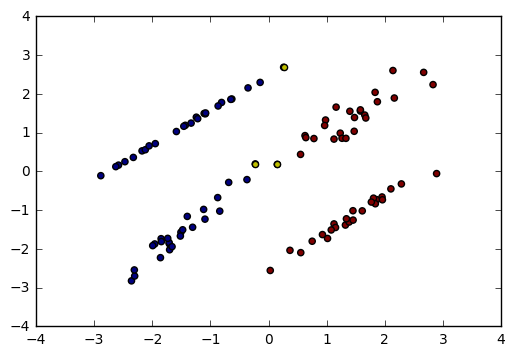

In [610]:
#plot the support vectors in yellow.
plt.scatter(X.T[0], X.T[1], c=t)
plt.scatter(X[np.where(sv)[0]].T[0], X[np.where(sv)[0]].T[1],c='y')

In [611]:
w = (lm*y).T.dot(X) #compute the weight vector

In [612]:
sv1 = np.where(sv)[0][0] #we can compute the intercept using any support vector, as the know y(x) is 1 or -1 for these points.
t[sv1] # this sv has label -1

array([-1])

Predictive function given by
$y(x^{*}) = \sum_{n} a_{n}t_{n}k(x_{n},x^{*}) +b$

For a support vector, we know $y(x^{*})$, so rearrange to compute b.

$b= y(x^{*})-\sum_{n} a_{n}t_{n}k(x_{n},x^{*})$

In [613]:
b=y[sv1]-np.sum(lm*t*kernel(X, X[sv1]).reshape((n_samples,1))) 

In [614]:
Xtest = np.array([1.0,-3.0]).reshape((1,2)) # lets try a test point

In [615]:
pred=(b+np.sum(lm*t*kernel(X, Xtest).reshape((X.shape[0],1))))
print("Point classified as class", int(pred/abs(pred)))

('Point classified as class', 1)


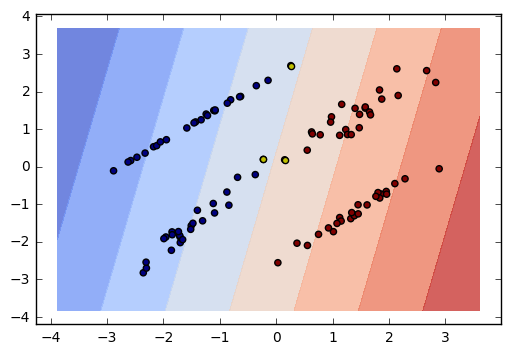

In [616]:
#Just some code to plot the decision surface.
h=0.5
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
po=(np.c_[xx.ravel(), yy.ravel()])
Z=(b+np.sum(lm*t*kernel(X, po), axis=0))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X.T[0], X.T[1], c=y)
plt.scatter(X[np.where(sv)[0]].T[0], X[np.where(sv)[0]].T[1],c='y')